In [3]:
import sys
print("Python Version:", sys.version)

Python Version: 3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]


In [4]:
#######################
# standard code block #
#######################

%config InlineBackend.figure_format = 'svg'

# auto reload imports that change
%load_ext autoreload
# only set to auto reload for marked imports
%autoreload 1

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import os

## Read Text Files

### Sensor File Descriptions

|Sensor		|Physical quantity				|Unit	|Sampling rate|
|-----------|-------------------------------|-------|-------------|
|PS1		|Pressure						|bar	|       100 Hz|
|PS2		|Pressure						|bar	|       100 Hz|
|PS3		|Pressure						|bar	|		100 Hz|
|PS4		|Pressure						|bar	|		100 Hz|
|PS5		|Pressure						|bar	|		100 Hz|
|PS6		|Pressure						|bar	|		100 Hz|
|EPS1		|Motor power				    |W		|		100 Hz|
|FS1		|Volume flow					|l/min	|		 10 Hz|
|FS2		|Volume flow					|l/min	|		 10 Hz|
|TS1		|Temperature					|&deg;C	|		  1 Hz|
|TS2		|Temperature					|&deg;C	|		  1 Hz|
|TS3		|Temperature					|&deg;C |		  1 Hz|
|TS4		|Temperature					|&deg;C |		  1 Hz|
|VS1		|Vibration						|mm/s	|		  1 Hz|
|CE			|Cooling efficiency (virtual)	|%		|		  1 Hz|
|CP			|Cooling power (virtual)		|kW		|		  1 Hz|
|SE			|Efficiency factor				|%		|		  1 Hz|

### Target file Description

Targets are stored in profile.txt in form:
```
1: Cooler condition / %:
	3: close to total failure
	20: reduced effifiency
	100: full efficiency

2: Valve condition / %:
	100: optimal switching behavior
	90: small lag
	80: severe lag
	73: close to total failure

3: Internal pump leakage:
	0: no leakage
	1: weak leakage
	2: severe leakage

4: Hydraulic accumulator / bar:
	130: optimal pressure
	115: slightly reduced pressure
	100: severely reduced pressure
	90: close to total failure

5: stable flag:
	0: conditions were stable
	1: static conditions might not have been reached yet
```

### Read into Dataframes

In [6]:
files = [
    'CE.txt', 'EPS1.txt', 'PS1.txt', 'PS5.txt', 'TS2.txt',
    'CP.txt', 'FS1.txt', 'PS2.txt', 'PS6.txt', 'TS3.txt',
    'FS2.txt', 'PS3.txt', 'SE.txt', 'TS4.txt',
    'profile.txt', 'PS4.txt', 'TS1.txt', 'VS1.txt'
]

In [7]:
# get path to raw data
data_dir = os.path.abspath('../data/raw')

# list of dataframes
file_dfs = {}

In [8]:
# read files into dict with table names (file without .txt)
for file in files:
    file_dfs[file[:-4]] = pd.read_csv(f'{data_dir}/{file}', sep='\t', header=None)

### Rename Target Columns

In [9]:
# name target columns according to description
file_dfs['profile'] = (
    file_dfs['profile'].rename({
        0:'cooler_eff', 1:'valve_perc', 2:'pump_leak',
        3:'accu_prs', 4:'stable'
    }, axis='columns')
)

In [10]:
# rename columns according to time in test
for name, df in file_dfs.items():
    
    if name != 'profile':
        
        # time interval of the sensor
        time_int = 60/len(df.columns)

        # new_cols is in seconds, i.e. 0.1, 0.2, 0.3...
        new_cols = df.columns * time_int + time_int
        old_cols = df.columns.values
    
        # dict for df.rename()
        colnames = dict(zip(old_cols, new_cols))
        
        # rename
        file_dfs[name] = df.rename(colnames, axis='columns')

## Sensor Plots

### Schematics

![alt text](../reports/figures/hydr_schematic.gif "a. Hydraulic  
b. Cooling")

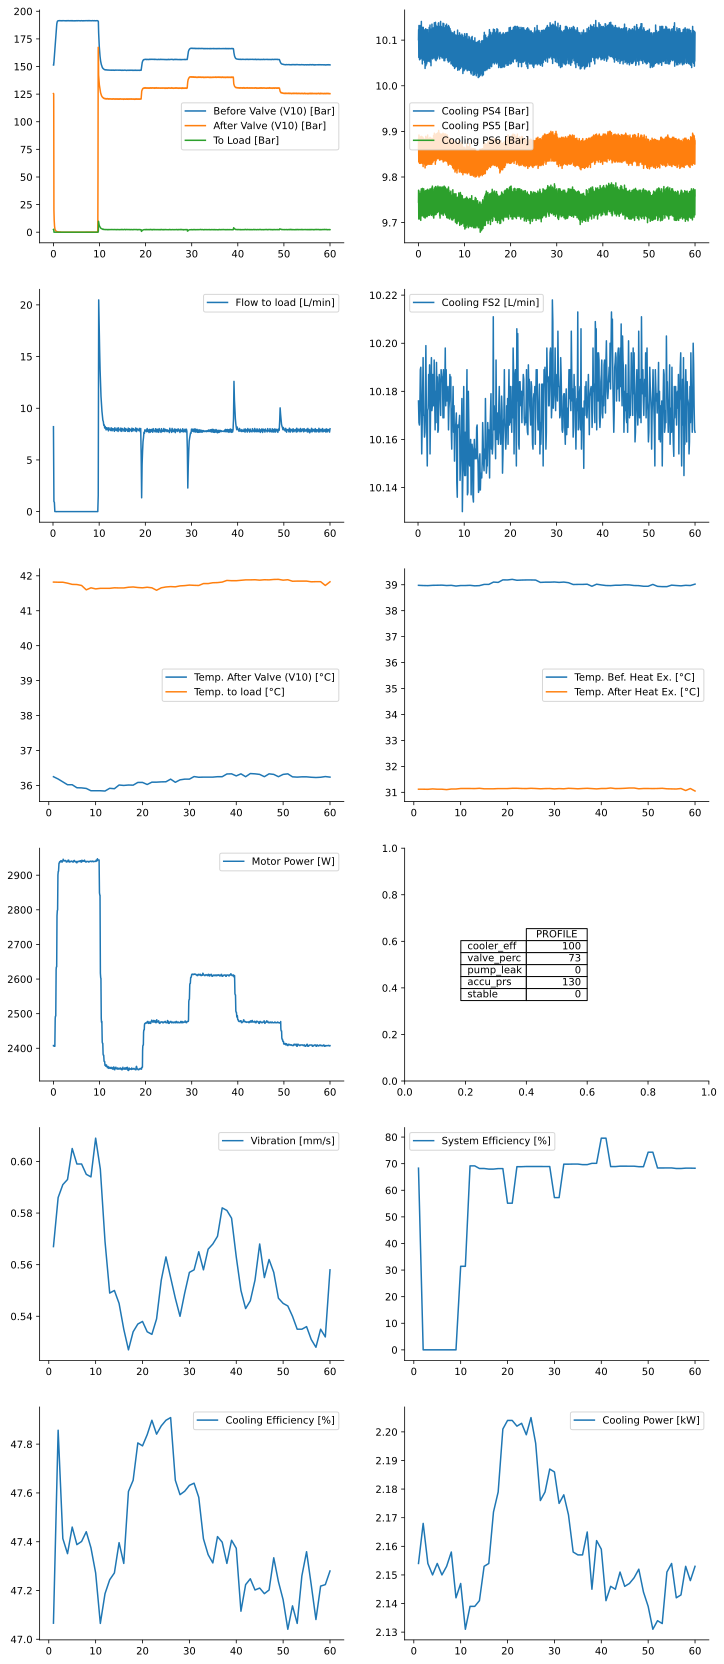

In [11]:
# test number and subplot setup
testno = 1766
fig, axis = plt.subplots(ncols=2, nrows=6, figsize=(12,30))

# pressure sensors
sns.lineplot(data=file_dfs[f'PS1'].loc[testno,:], label='Before Valve (V10) [Bar]', ax=axis[0][0])
sns.lineplot(data=file_dfs[f'PS2'].loc[testno,:], label='After Valve (V10) [Bar]', ax=axis[0][0])
sns.lineplot(data=file_dfs[f'PS3'].loc[testno,:], label='To Load [Bar]', ax=axis[0][0])
sns.lineplot(data=file_dfs[f'PS4'].loc[testno,:], label='Cooling PS4 [Bar]', ax=axis[0][1])
sns.lineplot(data=file_dfs[f'PS5'].loc[testno,:], label='Cooling PS5 [Bar]', ax=axis[0][1])
sns.lineplot(data=file_dfs[f'PS6'].loc[testno,:], label='Cooling PS6 [Bar]', ax=axis[0][1])

# flow sensors
sns.lineplot(data=file_dfs['FS1'].loc[testno,:], label='Flow to load [L/min]', ax=axis[1][0])
sns.lineplot(data=file_dfs['FS2'].loc[testno,:], label='Cooling FS2 [L/min]', ax=axis[1][1])

# temperature
sns.lineplot(data=file_dfs['TS1'].loc[testno,:], label='Temp. After Valve (V10) [°C]', ax=axis[2][0])
sns.lineplot(data=file_dfs['TS2'].loc[testno,:], label='Temp. to load [°C]', ax=axis[2][0])
sns.lineplot(data=file_dfs['TS3'].loc[testno,:], label='Temp. Bef. Heat Ex. [°C]', ax=axis[2][1])
sns.lineplot(data=file_dfs['TS4'].loc[testno,:], label='Temp. After Heat Ex. [°C]', ax=axis[2][1])

# motor power
sns.lineplot(data=file_dfs['EPS1'].loc[testno,:], label='Motor Power [W]', ax=axis[3][0])

# motor vibration
sns.lineplot(data=file_dfs['VS1'].loc[testno,:], label='Vibration [mm/s]', ax=axis[4][0])

# efficiency factor
sns.lineplot(data=file_dfs['SE'].loc[testno,:], label='System Efficiency [%]', ax=axis[4][1])

# cooling efficiency
sns.lineplot(data=file_dfs['CE'].loc[testno,:], label='Cooling Efficiency [%]', ax=axis[5][0])

# cooling power
sns.lineplot(data=file_dfs['CP'].loc[testno,:], label='Cooling Power [kW]', ax=axis[5][1])

# target values
axis[3, 1].table(cellText=file_dfs['profile'].loc[testno,:].astype(str).values.reshape((5, 1)),
          rowLabels=file_dfs['profile'].loc[testno,:].index.values,
          loc='center', colWidths=[0.2], colLabels=['PROFILE']
         )
sns.despine()

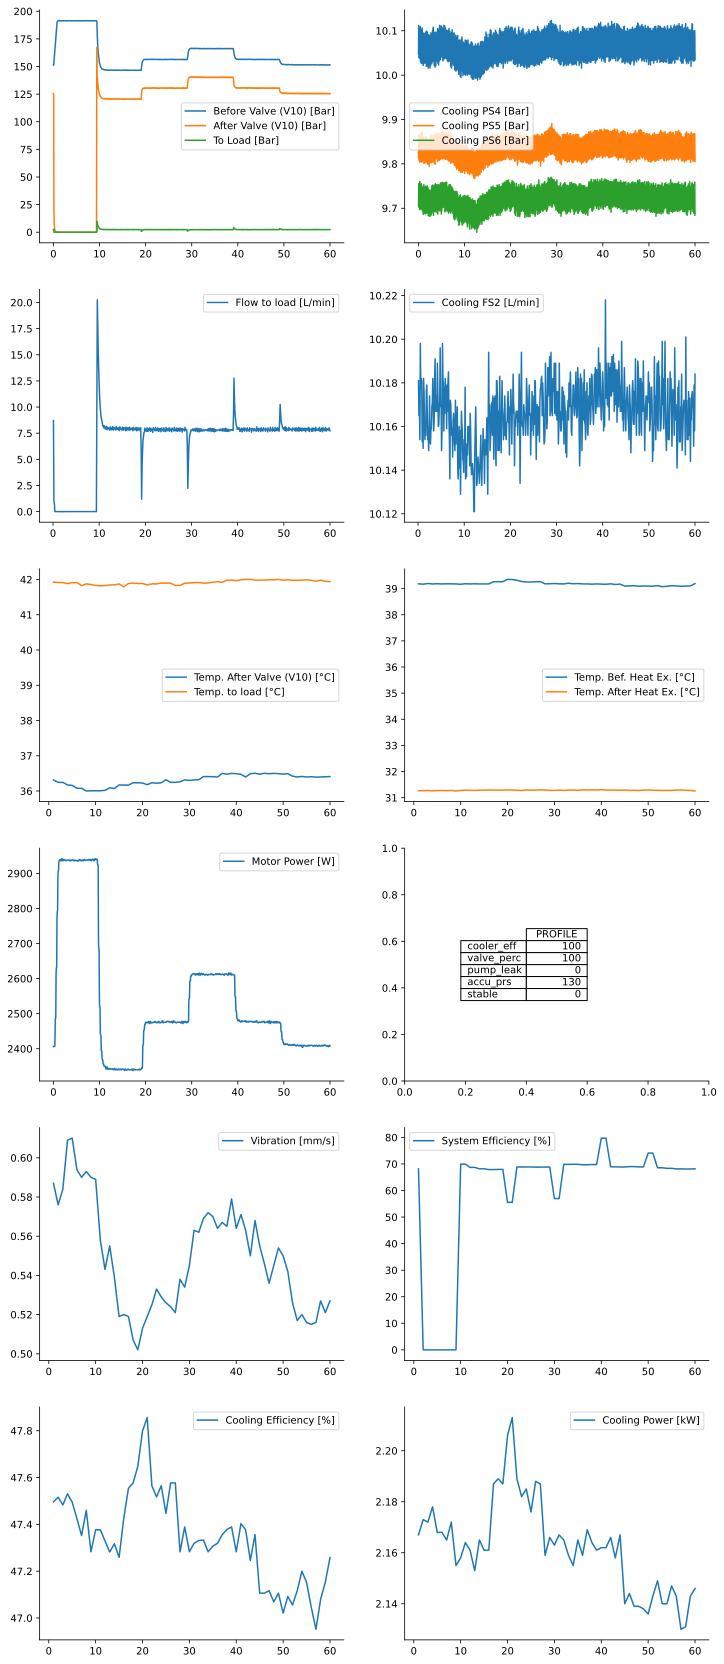

In [12]:
# test number and subplot setup
testno = 1796
fig, axis = plt.subplots(ncols=2, nrows=6, figsize=(12,30))

# pressure sensors
sns.lineplot(data=file_dfs[f'PS1'].loc[testno,:], label='Before Valve (V10) [Bar]', ax=axis[0][0])
sns.lineplot(data=file_dfs[f'PS2'].loc[testno,:], label='After Valve (V10) [Bar]', ax=axis[0][0])
sns.lineplot(data=file_dfs[f'PS3'].loc[testno,:], label='To Load [Bar]', ax=axis[0][0])
sns.lineplot(data=file_dfs[f'PS4'].loc[testno,:], label='Cooling PS4 [Bar]', ax=axis[0][1])
sns.lineplot(data=file_dfs[f'PS5'].loc[testno,:], label='Cooling PS5 [Bar]', ax=axis[0][1])
sns.lineplot(data=file_dfs[f'PS6'].loc[testno,:], label='Cooling PS6 [Bar]', ax=axis[0][1])

# flow sensors
sns.lineplot(data=file_dfs['FS1'].loc[testno,:], label='Flow to load [L/min]', ax=axis[1][0])
sns.lineplot(data=file_dfs['FS2'].loc[testno,:], label='Cooling FS2 [L/min]', ax=axis[1][1])

# temperature
sns.lineplot(data=file_dfs['TS1'].loc[testno,:], label='Temp. After Valve (V10) [°C]', ax=axis[2][0])
sns.lineplot(data=file_dfs['TS2'].loc[testno,:], label='Temp. to load [°C]', ax=axis[2][0])
sns.lineplot(data=file_dfs['TS3'].loc[testno,:], label='Temp. Bef. Heat Ex. [°C]', ax=axis[2][1])
sns.lineplot(data=file_dfs['TS4'].loc[testno,:], label='Temp. After Heat Ex. [°C]', ax=axis[2][1])

# motor power
sns.lineplot(data=file_dfs['EPS1'].loc[testno,:], label='Motor Power [W]', ax=axis[3][0])

# motor vibration
sns.lineplot(data=file_dfs['VS1'].loc[testno,:], label='Vibration [mm/s]', ax=axis[4][0])

# efficiency factor
sns.lineplot(data=file_dfs['SE'].loc[testno,:], label='System Efficiency [%]', ax=axis[4][1])

# cooling efficiency
sns.lineplot(data=file_dfs['CE'].loc[testno,:], label='Cooling Efficiency [%]', ax=axis[5][0])

# cooling power
sns.lineplot(data=file_dfs['CP'].loc[testno,:], label='Cooling Power [kW]', ax=axis[5][1])

# target values
axis[3, 1].table(cellText=file_dfs['profile'].loc[testno,:].astype(str).values.reshape((5, 1)),
          rowLabels=file_dfs['profile'].loc[testno,:].index.values,
          loc='center', colWidths=[0.2], colLabels=['PROFILE']
         )
sns.despine()